# Verursacht Temu eine Erhöhung von Frachtflüfgen von China nach Europa? (Zweiter Datensatz)

Max Köhler/SWR DataLab (max.koehler@swr.de), 22. Oktober 2024


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from os import listdir
from os.path import isfile, join

In [2]:
# Proprietary flight data
file_dirs = ["./data/china-germany", "./data/china-belgium", "./data/china-netherlands"]
flights = pd.DataFrame()
for fd in file_dirs:
	filenames = [f for f in listdir(fd) if isfile(join(fd, f))]
	print(f"Reading {fd}: {len(filenames)} data files found")
	for fn in filenames:
		path = f"{fd}/{fn}"
		flights = pd.concat([flights, pd.read_csv(path, parse_dates=["date"])])


# Public domain airport data (https://ourairports.com/data/)
airports = pd.read_csv("./data/airports.csv")

Reading ./data/china-germany: 1 data files found
Reading ./data/china-belgium: 94 data files found
Reading ./data/china-netherlands: 94 data files found


In [3]:
# Drop airports without IATA codes
airports = airports.drop(
    airports[
        (airports["iata_code"].isnull())
     	| (airports["iata_code"] == "nan")
  	].index)

# Select landing events with destination IATA Codes
takeoffs = flights[
			(flights["destination_iata"].notnull())
    & (flights["event"] == "takeoff")
        ].drop_duplicates().reset_index(drop=True)

print(f"{takeoffs.shape[0]} takeoffs found.")

takeoffs["year_week"] = takeoffs["date"].apply(lambda x: f"{x.isocalendar()[0]}-{x.isocalendar()[1]}")
takeoffs

610506 takeoffs found.


,address,altitude,callsign,date,destination_iata,destination_icao,equipment,event,flight,flight_id,latitude,longitude,operator,origin_iata,origin_icao,registration,time,year_week
0,3C4581,150,BOX303,2023-01-01,LEJ,EDDP,B77L,takeoff,3S303,783648915,26.27795,50.62120,BOX,BAH,OBBI,D-AALA,01:19:33,2022-52
1,A82AA0,150,UPS76,2023-01-01,SZX,ZGSZ,B748,takeoff,5X76,783653675,25.26376,55.35233,UPS,DXB,OMDB,N625UP,02:24:57,2022-52
2,3C542F,1675,BCS7JG,2023-01-01,LEJ,EDDP,A306,takeoff,NaN,783653718,40.49966,-3.57468,BCS,MAD,LEMD,D-AEAO,00:16:10,2022-52
3,06A081,2375,QTR8961,2023-01-01,ICN,RKSI,B77L,takeoff,QR8961,783654423,31.21332,121.81465,QTR,PVG,ZSPD,A7-BFC,00:09:12,2022-52
4,800CF5,125,SEJ7635,2023-01-01,KMG,ZPPP,B737,takeoff,SG7635,783656090,22.65907,88.44833,SEJ,CCU,VECC,VT-SFB,00:55:53,2022-52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610501,AC7364,75,FDX6335,2024-10-14,CDG,LFPG,B752,takeoff,FX6335,931889185,52.34711,4.71039,FDX,AMS,EHAM,N901FD,20:48:39,2024-42
610502,896356,5100,ETD957,2024-10-14,AMS,EHAM,B77L,takeoff,EY957,931892095,-1.32269,36.92292,ETD,NBO,HKJK,A6-DDB,20:56:16,2024-42
610503,4841C4,5100,MP8372,2024-10-14,AMS,EHAM,B744,takeoff,MP8372,931900085,-1.32297,36.92258,MPH,NBO,HKJK,PH-CKB,21:36:39,2024-42
610504,71BE17,150,KAL517,2024-10-14,AMS,EHAM,B748,takeoff,KE517,931912101,37.44635,126.43914,KAL,ICN,RKSI,HL7617,22:54:09,2024-42


In [4]:
# Merge airports on destination_iata
merged_flights = pd.merge(
	takeoffs,
	airports[["iata_code", "iso_country"]],
	how="left",
	left_on=["destination_iata"],
	right_on="iata_code").drop("iata_code", axis=1)

merged_flights["destination_country"] = merged_flights["iso_country"]
merged_flights.drop("iso_country", axis=1, inplace=True)

# Merge airports on origin_iata
merged_flights = pd.merge(
	merged_flights,
	airports[["iata_code", "iso_country"]],
	how="left",
	left_on=["origin_iata"],
	right_on="iata_code").drop("iata_code", axis=1)

merged_flights["origin_country"] = merged_flights["iso_country"]
merged_flights.drop("iso_country", axis=1, inplace=True)

missed_destination = merged_flights.loc[merged_flights["destination_country"].isnull()].shape[0]
missed_origin = merged_flights.loc[merged_flights["origin_country"].isnull()].shape[0]

print(f'Failed to set origin country for {missed_origin} flights ({round(missed_origin / takeoffs.shape[0] * 100, 2)}%) and destination country for {missed_destination} flights ({round(missed_destination / takeoffs.shape[0] * 100, 2)}%),\nlikely because their IATA codes are missing from our airport data.')

Failed to set origin country for 2922 flights (0.48%) and destination country for 1026 flights (0.17%),
likely because their IATA codes are missing from our airport data.


In [5]:
eu_countries = ("BE", "DE", "NL")

# Flights from any Chinese airport that landed in any Belgian, German, or Dutch airport
flights_china_eu = merged_flights.loc[
    (merged_flights["origin_country"] == "CN")
    & (merged_flights["destination_country"].isin(eu_countries))]

years = [2023, 2024]

results = pd.DataFrame()

for y in years:
    result = pd.DataFrame({"year": [y]})
    year_flights = flights_china_eu.loc[flights_china_eu["date"].dt.year == y]
    result["total"] = year_flights.shape[0]
    for c in eu_countries:
    	result[c] = year_flights.loc[year_flights["destination_country"] == c].shape[0]
    results = pd.concat([results, result], ignore_index=True)
    
results["change_to_prev"] = results["total"].divide(results["total"].shift(periods=1)).add(-1)
results

,year,total,BE,DE,NL,change_to_prev
0,2023,5137,1021,2497,1619,NaN
1,2024,4140,853,2007,1280,-0.194082


## Ergebnisse

### Welche Daten liegen vor?

Die 189 vorliegenden CSV-Dateien enthalten Daten für weltweite, von FlightRadar24 erfasste Flüge im Zeitraum 01.01.2023-2024. Jeder Flug ist in einer Zeile repräsentiert einen Flug (es gibt Duplikate, aber diese werden in dieser Analyse bereits herausgefiltert). Insgesamt wurden 610.506 Flüge erfasst.

Zu jedem Flug werden eine Reihe von mehr oder weniger interessanten Metadaten angegeben. Die Spalte `event` enthält die Art des erfassten Flgereignisse. Anders als der erste Datensatz enthält vorliegende nur Ereignisse vom Typ `takeoff`. Die Spalten `origin_iata` und `destination_iata` sind Flughafen-Codes die wir relativ leicht Ländern oder Regionen zuordnen können (siehe oben). Lufthansa Cargo LH8403 von Shanghai Pudong International (`PVD`) nach Frankfurt (`FRA`) am 01.01.2023 ist zum Beispiel so repräsentiert:


In [6]:
merged_flights.loc[(merged_flights["flight_id"] == 783664172)]

,address,altitude,callsign,date,destination_iata,destination_icao,equipment,event,flight,flight_id,latitude,longitude,operator,origin_iata,origin_icao,registration,time,year_week,destination_country,origin_country
26,3C70C1,2775,GEC8403,2023-01-01,ICN,RKSI,B77L,takeoff,LH8403,783664172,31.24465,121.82097,GEC,PVG,ZSPD,D-ALFA,02:22:59,2022-52,KR,CN


### Kann man an den Daten erhöhten Flugverkehr durch Temu erkennen?

**Nein**. Aus der letzten Analyse wurde ersichtlich, dass "zwischen dem Start von Temu in 2023 und 2024 die Zahl der Flüge von China nach Europa um 36.3% gestiegen" ist. Mehr kann man aus den vorliegenden Daten auch nicht ablesen. Das Flugaufkommen fluktuiert, ein _Temu Spike_ ist nicht zu erkennen.


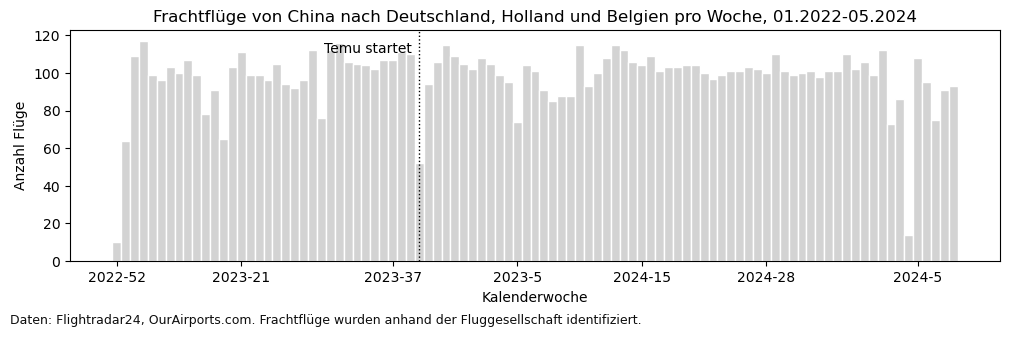

In [7]:
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

days = pd.DataFrame(pd.date_range(start='7/1/2019', end='10/1/2024', freq="W", name="date"))
months = pd.DataFrame(pd.date_range(start='7/1/2019', end='10/1/2024', freq="M", name="date"))
flights_per_month = flights_china_eu.groupby(takeoffs.year_week).size()

labels = pd.DataFrame([
	{"date": "2023-4", "text": "Temu startet", "y_offset": 0, "source": "https://www.reuters.com/technology/chinese-owned-e-commerce-platform-temu-expands-europe-2023-04-25/"},
])

fig,ax = plt.subplots(figsize=(12,3))
ax.set_title("Frachtflüge von China nach Deutschland, Holland und Belgien pro Woche, 01.2022-05.2024")
ax.bar(
	x=flights_per_month.index,
	height=flights_per_month.values,
	label="Anzahl Flüge",
	color="lightgray",
	width=1,
	edgecolor="white"
)
ax.xaxis.set_major_locator(locator)
ax.set_xlabel("Kalenderwoche")
ax.set_ylabel("Anzahl Flüge")

for index, l in labels.iterrows():
	ax.axvline(x=l["date"], color="black", lw=1, zorder=10, linestyle=":")
	ax.annotate(
		zorder=200,
		text=l["text"],
		xy=(l["date"], 0),
		horizontalalignment="right",
		textcoords=("offset fontsize","axes fraction"),
		xytext=(-.5,.9)
	)

ax.text(x=0.075, y=-0.1, s="Daten: Flightradar24, OurAirports.com. Frachtflüge wurden anhand der Fluggesellschaft identifiziert.", transform=fig.transFigure, ha='left', fontsize=9, alpha=.95, linespacing=1.35)
plt.show()